# COMP1816 Tutorial Week 3 - Multivariable Models & Model Selection


This tutorial will be expanding on the work done in week 2 on Linear Regression. First of all we will go through some more basic prinicples of performing an EDA, data cleaning and other proprocessing, then we will fit multivariable and polynomial models to our processed data.

For this tutorial, read through and try to understand the text and code examples I have provided (ask your tutor if you have any questions) and there will be a selection of exercises. Attempt these exercises on your own, but do ask your tutor for help if you get stuck.



# 0. Do not forget to import all the Python Libraries being used!

In [ ]:
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import sklearn.linear_model, sklearn.datasets # We want to be able to access the sklearn datasets again, also we are using some model evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler # We will be using the imbuilt sclaing functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
from sklearn.preprocessing import PolynomialFeatures # A preprocessing function allowing us to include polynomial features into our model
from google.colab import files # We will be importing a csv file I have provided for one section.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # We will be using these to encode categorical features
from sklearn.model_selection import train_test_split # An sklearn library for outomatically splitting our data
from sklearn.impute import SimpleImputer # Performs basic imputations when doing preprocessing
pd.options.mode.chained_assignment = None  # default='warn'

# 1. Data Pre-Processing

A key part of any Machine Learning (or Data science in general) implementation is making sure that you understand your data and have prepared it to be in the most appropriate form for any modelling you intend to perform.

As a rough rule, this stage involves performing an Exploratory Data Analysis (EDA) the help you understand our data and pre-processing which alters the data to put it into the format we want, which can include both data cleaning and steps that fundamentally change the data to make it work better with our models (such as the feature scaling examined last week, and the categorical feature encoding and polynomial feature creation we have introduced this week). This is a big topic on it's own, with differnt potential workflows that could lead to these results and we only scrape the surface in this module.

## 1.1 Loading

For this problem, I have created a synthetic dataset which I have uploaded to moodle which has a number of issues we need to address before we can fit a good model. Please load this csv below (you will first have to download the file to your local file system from moodle).



In [ ]:
uploaded = files.upload()    # Will prompt you to select file
# Your file is now in the Colab filesystem on the left
testData = pd.read_csv('examData_1.csv') # Save it to a pandas dataframe

This data shows the final grade of a selection of students from 4 different schools. We have the scores from their previous two mock papers and a quiz, but there are also a number of catgorical feature columns that we can't currently use.

## 1.1 EDA
Let's have a look at the data:

In [ ]:
# show the data
display(testData)

,studentID,mock1,mock2,quiz,studyTime,travelTime,absence,school,finalGrade
0,KCI0001,47.0,58.0,12,241-480,61-120,No,KCI,75
1,KCI0002,58.0,80.0,15,241-480,61-120,No,KCI,94
2,KCI0003,19.0,32.0,5,121-240,61-120,Yes,KCI,19
3,KCI0004,30.0,45.0,15,241-480,61-120,No,KCI,63
4,KCI0005,36.0,58.0,11,121-240,0-30,Yes,KCI,53
...,...,...,...,...,...,...,...,...,...
395,QE200097,57.0,83.0,13,241-480,0-30,No,QE2,97
396,QE200098,55.0,55.0,13,241-480,31-60,No,QE2,64
397,QE200099,42.0,54.0,7,121-240,61-120,No,QE2,54
398,QE200100,55.0,49.0,11,241-480,61-120,No,QE2,55


One thing you may notice is that while the first three columns are numerical, the rest of the data is all comprised of strings. So far we have only been considering feature columns that have been populated with numerical data, however it is not unusual to encounter datasets where the feature columns may include text values that have some meaning for the target predictions, however these must be converted into a numerical form somehow in order to be used by the machine learning algorithms.

I will cover how to treat these 'categorical features' in our ML models later in the tutorial, but for now we will just consider how to fix any data problems we can find.

First, let's split off our target and full feature matrix from the complete dataframe:

In [ ]:
features=['studentID', 'mock1', 'mock2','quiz','studyTime','travelTime','absence','school']
X_raw = testData[features]
y_raw = testData['finalGrade']

Using the `shape` function is a good way of easily finding the dimensions of your dataset - in this case 8 columns (features) and 400 rows (data entries).

In [ ]:
print(X_raw.shape)

(400, 8)


Let's just check our new `X_raw` is okay - this time I'm just using the head command which will only take the top (5 by default, but you can set the number in the brackets) rows, which is a useful function for just quikly checking the state of your data.

In [ ]:
display(X_raw.head())

,studentID,mock1,mock2,quiz,studyTime,travelTime,absence,school
0,KCI0001,47.0,58.0,12,241-480,61-120,No,KCI
1,KCI0002,58.0,80.0,15,241-480,61-120,No,KCI
2,KCI0003,19.0,32.0,5,121-240,61-120,Yes,KCI
3,KCI0004,30.0,45.0,15,241-480,61-120,No,KCI
4,KCI0005,36.0,58.0,11,121-240,0-30,Yes,KCI


Something we should always be thinking about is whether we actually want to use all of our columns, as we certainly don't want to include any irrelevant data in our features. In this case the studentID won't contribute anything to the model, as it is a unqiue identifier for each row, so we can safely remove this. But there can be other examples where data is collected but it just is not relevant to the target we are being asked to predict - such as if we also had information on the eye/hair colour of the students we would also almost certainly want that removed as these will be irrelvant for predicting their grades.

In [ ]:
X_raw = X_raw.drop(columns=['studentID']) # Remove the studentID column using '.drop'
display(X_raw.head())

,mock1,mock2,quiz,studyTime,travelTime,absence,school
0,47.0,58.0,12,241-480,61-120,No,KCI
1,58.0,80.0,15,241-480,61-120,No,KCI
2,19.0,32.0,5,121-240,61-120,Yes,KCI
3,30.0,45.0,15,241-480,61-120,No,KCI
4,36.0,58.0,11,121-240,0-30,Yes,KCI


At this stage we need to start considering our numeric and categorical columns seperately, as the methods we use to clean and otherwise preprocess them are quite different. For now we want to keep them together in the raw data, but we can easily view them seperately.

In [ ]:
display(X_raw.select_dtypes(include=np.number).head(10)) # display numeric colmuns
display(X_raw.select_dtypes(exclude=np.number).head(10)) # display non-numeric colmuns

,mock1,mock2,quiz
0,47.0,58.0,12
1,58.0,80.0,15
2,19.0,32.0,5
3,30.0,45.0,15
4,36.0,58.0,11
5,38.0,37.0,11
6,56.0,67.0,13
7,46.0,64.0,12
8,35.0,38.0,7
9,63.0,59.0,13


,studyTime,travelTime,absence,school
0,241-480,61-120,No,KCI
1,241-480,61-120,No,KCI
2,121-240,61-120,Yes,KCI
3,241-480,61-120,No,KCI
4,121-240,0-30,Yes,KCI
5,241-480,61-120,No,KCI
6,61-120,0-30,Yes,KCI
7,61-120,61-120,Yes,KCI
8,241-480,61-120,No,KCI
9,241-480,61-120,No,KCI


## 1.2 Dealing with outliers
The best way to deal with outliers is always an open question - in fact, what even counts as an outlier is not always clear. We want to distinguish between outliers that tell us something (which we will often want to include in our model) and outliers that are clearly the result of errors. Once outliers are identified, you really need to treat them on a case by case basis - if there is a mistake, are you able to use your domain knowledge to fix it? Or will it be better to remove that data, either just that entry (leaving us with a blank entry we can impute - we will cover this later) or possibly the entire data row.

First let's look at the numerical columns and see if there are any obvious outliers:

In [ ]:
display(X_raw.select_dtypes(include=np.number).describe())

,mock1,mock2,quiz
count,396.000000,397.000000,398.000000
mean,50.174242,55.254408,10.806533
std,15.346049,18.064091,2.383879
min,9.000000,0.000000,4.000000
25%,40.000000,43.000000,9.000000
50%,50.000000,54.000000,11.000000
75%,61.000000,67.000000,12.000000
max,85.000000,100.000000,17.000000


Describing numerical columns will provide us with various statistical information about our columns (Min, Max, Count, mean, standard deviation, quartiles). A few things jump out to me:

*   The counts are low - we know there are supposed to be 400 data entires, so this would indicate we are missing values from all columns. More on how to deal with missing data later.
*   The '-10' in mock1 seems to be an outlier, as the values are between 1 and 100.
*   There seems to be at least one outlier in mock2, with a maximum value of '1000', which again seems to be way out of range.
*   In the quiz there is a max value of 76 observed. Now, I would assume that this is an outlier as the rest of the values are in the range 0-20, so I will count this as an outlier. However, if we were not given information about the quiz score range it could be possible that this is accurate and just every other person really flunked this quiz marked out of 100.

Assuming that the mocks are in the range 0-100 and the quiz in teh range 0-20, let's check for all the outlier rows:




In [ ]:
print(X_raw[(X_raw['mock1'] < 0) | (X_raw['mock1'] > 100) | (X_raw['mock2'] < 0) | (X_raw['mock2'] > 100) | (X_raw['quiz'] < 0) | (X_raw['quiz'] > 20)])

     mock1   mock2  quiz studyTime travelTime absence school
41    38.0   200.0    21      0-60      31-60      No    KCI
43    80.0  1000.0    14   121-240     61-120      No    KCI
88    71.0    76.0    76   241-480      31-60      No    KCI
219  -10.0     NaN    14   241-480     61-120      No    KHV


Looking at this, there seens to be an extra potenteial outlier at line 41, where mock2 is '200' and quiz is '21. It's safe to assume that both lines 41 and 43 are outiers by error given our knowledge of the data. For line 43, given the other scores I would assume this is a typo and the students actually scored 100. Line 41 is less clear, as mock 1 was quite bad but mock2 and the quiz are both over the limit. It may not be a bad idea to remove both of these values and impute them, or possibly remove the entire line. Same arguement can be made for line 219 with quite a lot of missing data. Finally, line 88 has '76' for the quiz, which looks like a typo to me as this was the score they got for their mock2, however, this means we don't have anyhting to go on for the actual quiz score.

We're unfortuantely going to have to treat these outlier quite specifically, but you may be able to set up a more general rule (e.g. remove any row/value outside of a certain threshold) in other cases.

In [ ]:
# Row 43 - Set the 1000 to be 100
X_raw.loc[X_raw.mock2==1000,'mock2'] = 100
# Row 41 - I don't trust the mock or the quiz score, and don't feel we can make any assumpions ourself, so I will just remove them
# Row 88 - Likewise, we can't trust the quiz score, so remove it
X_raw.loc[X_raw.mock2==200,'mock2'] = np.nan
X_raw.loc[X_raw.quiz>20,'quiz'] = np.nan
# Row 219 - Let's just set the negative to be a zero, but we could also justify removing the data point or even the entire row.
X_raw.loc[X_raw.mock1<0,'mock1'] = np.nan
print(X_raw[(X_raw['mock1'] < 0) | (X_raw['mock1'] > 100) | (X_raw['mock2'] < 0) | (X_raw['mock2'] > 100) | (X_raw['quiz'] < 0) | (X_raw['quiz'] > 20)])

Empty DataFrame
Columns: [mock1, mock2, quiz, studyTime, travelTime, absence, school]
Index: []


Now we need to consider the categorical columns. We can see there is still come missing data here, but I think we have a problem with 'absence' as is should only be binary yes/no.

In [ ]:
display(X_raw.select_dtypes(exclude=np.number).describe())

,studyTime,travelTime,absence,school
count,398,398,397,400
unique,4,3,3,4
top,241-480,61-120,No,KCI
freq,206,214,318,113


Let's try checking the unique values for each cateogrical column:

In [ ]:
print(pd.unique(X_raw['studyTime']))
print(pd.unique(X_raw['travelTime']))
print(pd.unique(X_raw['absence']))
print(pd.unique(X_raw['school']))

['241-480' '121-240' '61-120' '0-60' nan]
['61-120' '0-30' '31-60' nan]
['No' 'Yes' nan 'Absent']
['KCI' 'KGV' 'KHV' 'QE2']


The rest seem fine (NaNs aside, which we will fix soon), but the problem with 'absence' is that someone was marked as 'Absent', but in this column that is the same as being flagged 'Yes', so let's fix that:

In [ ]:
X_raw["absence"] = X_raw["absence"].apply(lambda x: str(x).replace("Absent", "Yes"))

print(pd.unique(X_raw['absence']))

['No' 'Yes' 'nan']


## 1.4 Data Splitting

Now that the outliers are dealt with, it is time to start setting up our machine learning workflow. As demonstrated in the lecture, it is actually critical that we hold back some data that our model hasn't been trained on to evaluate it's performance when being tested on new data (as this is the entire point of making these models, after all). I will talk about the theory behind data splitting in much more detail next week, but for now we will just hold back $20\%$ as 'test; data, while we train our models using the other $80\%$. The easiest way to do this is using the sklearn `train_test_split` function.

In [ ]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.20, shuffle=True, random_state=0)

## 1.3 Data cleaning (imputation)

We've spotted a number of missing values in our data (NaNs), so the question is what to do about them - as we can't run our ML models with NaN values. Much like the outlier question, there is no one 'correct' way to approach this. If you have lots of data, maybe you feel you can get away with just removing the rows with incomplete data entirely. On the other end of the scale, maybe you will go and do more research to find out the missing values, or even use other models/statistics to work out the most likely value.

However, probably the easiest and most common approach is to use a naive imputation strategy.

This is done in a similar manner to the feature scaling done last week - we need to create a [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) object, `fit` this to our training data only, then use this to `transform` our train AND test data.

Note, there are 4 types of imputing this covers:
1.   'mean' - Numerical only, replaces missing values with the mean value for the feature.
2.   'median'- Numerical only, replaces missing values with the median value for the feature.
3.   'most frequent'- Numerical and categorical, replaces missing values with the most frequent (mode) value/string observed.
4.   'constant' - Numerical and categorical, replaces missing values with a defined constant value.

For this case, we are going to use a mean encoder on our numeric columns, and a most frequent strategy for our categorical columns.



In [ ]:
# To apply the different imputers, we first have to split our data into seperate numerical and categorical data
X_train_num = X_train_raw.select_dtypes(include=np.number)
X_train_cat = X_train_raw.select_dtypes(exclude=np.number)

# Create our imputer objects
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputers on the training data
numeric_imputer.fit(X_train_num)
categorical_imputer.fit(X_train_cat)

# Transform the columns
# Training
X_train_num_imp = numeric_imputer.transform(X_train_num)
X_train_cat_imp = categorical_imputer.transform(X_train_cat)

#We also need to split and transform our test data
X_test_num = X_test_raw.select_dtypes(include=np.number)
X_test_cat = X_test_raw.select_dtypes(exclude=np.number)
X_test_num_imp = numeric_imputer.transform(X_test_num)
X_test_cat_imp = categorical_imputer.transform(X_test_cat)

## 1.4 Feature Scaling

Another pre-procssing step that we want to consider at this point is the feature scaling you were shown last week. It's generally always a good idea to perform some kind of feature scaling on your numeric columns (note, categorical columns never need feature scaling!). In this case I will use Normalisation (MinMaxScaling), as I know the test/quiz results are within fixed bounds so there can't be any legitimate outliers to skew the scale, but standardisation should also work.

In [ ]:
# Scaler Object
scaler = MinMaxScaler()
# Fit on the numeric training data
scaler.fit(X_train_num_imp)
# Transform the training and test data
X_train_num_sca = scaler.transform(X_train_num_imp)
X_test_num_sca = scaler.transform(X_test_num_imp)


## 1.5 Categorical Feature Encoding

While we don't need to scale our categorical features, we still need to convert them into numerical values that our ML models can use. There are a few ways the problem of categorical features can be approached, but for now we will focus only on [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). For each feature, this expands the columns in the dataset to have one column per category using a 0/1 indicator to mark which category is true for each data point.

This is genrally considered a better solution than basic label encoding, as there is no ordering/scale between the categories being implied. However, there is actually is no benefit to using OHE for categorical features with only two catgories (as you will just end up with two columns where the 1's and 0's are inverted, which adds nothing to the model) and OHE can also cause an issue by causing the dimensionality of the data to increase, which brings it's own set of issues.

In [ ]:
# create the encoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Fit encoder on the training data
encoder.fit(X_train_cat_imp)
# Transform the test and train data
X_train_onehot = encoder.transform(X_train_cat_imp)
X_test_onehot = encoder.transform(X_test_cat_imp)

## 1.6 Pre-Processing Summary

Now we just need to pull our numerical and cateogrical columns back into a single feature matrix, which we can do like so:

In [ ]:
X_train = np.concatenate([X_train_num_sca, X_train_onehot], axis=1)
X_test = np.concatenate([X_test_num_sca, X_test_onehot], axis=1)

# We can see the scaled test results and the OHE category columns now.
print(X_train)

[[0.78873239 0.77       0.61538462 ... 0.         0.         1.        ]
 [0.1971831  0.34       0.30769231 ... 0.         0.         0.        ]
 [0.87323944 0.78       0.76923077 ... 0.         0.         0.        ]
 ...
 [0.54929577 0.43       0.92307692 ... 1.         0.         0.        ]
 [0.6056338  0.59       0.69230769 ... 0.         0.         0.        ]
 [0.63380282 0.74       0.69230769 ... 1.         0.         0.        ]]


And now our data should be fully prepared to be used with our ML models. While this process may have seemed very long going over it step by step, in practice most of the preprocessing only takes a few lines of code at the start of your implementation, some of which you might like to pull together into a function to make your code neater, but I will leave it down to you if you would like to implement that in your workflow.

# Fitting Machine Learning Models

## 2.1 Univariate example

Now we have our data in the right form, we can start experimenting with ML models. First, let's just give an example of how we would fit a univariate model - in this case using the first mock to predict the final grade.

Note: Below I have repeated the pre-processing steps that the data need, but just for the columns we're using rather than the whole data set. Strictly speaking we could just select the columns that we want from the final `X_train` matrix above (as we have now pre-processed all data), but I find the workflow below easier to follow as we can select the features by name at the start of the process. In this case we are only using numeric data so can also skip some pre-processing steps.

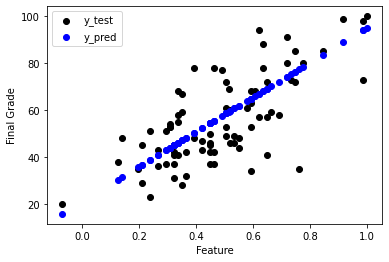

Train - MSE: 175.7562 R2 score: 0.5954
Test - MSE: 179.7717 R2 score: 0.4846


In [ ]:
# Select Columns - Remember the full list of features are:
# ['mock1', 'mock2','quiz','studyTime','travelTime','absence','school']
features = ['mock1']
X_raw_features = X_raw[features]

###############
# Preprocessing
###############
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw_features, y_raw, test_size=0.20, shuffle=True, random_state=0)

# Here we only have numerical data, so could skip this step.
X_train_num = X_train_raw.select_dtypes(include=np.number)

# Create our imputer objects
numeric_imputer = SimpleImputer(strategy='mean')

# Fit the imputers on the training data
numeric_imputer.fit(X_train_num)

# Transform the columns
# Training
X_train_num_imp = numeric_imputer.transform(X_train_num)

#We also need to split and transform our test data
X_test_num = X_test_raw.select_dtypes(include=np.number)
X_test_num_imp = numeric_imputer.transform(X_test_num)

# Scaler Object
scaler = MinMaxScaler()
# Fit on the numeric training data
scaler.fit(X_train_num_imp)
# Transform the training and test data
X_train_num_sca = scaler.transform(X_train_num_imp)
X_test_num_sca = scaler.transform(X_test_num_imp)

X_train = X_train_num_sca
X_test = X_test_num_sca

###################
# End preprocessing
###################

# Create linear regression object
obj = sklearn.linear_model.LinearRegression()

# Train the model using the training sets
obj.fit(X_train, y_train)

# We can make a prediction with the training data
y_pred_train = obj.predict(X_train)
# Remember the predictions with the new data give a better indiction of the true model performance.
# Make predictions using the testing set
y_pred = obj.predict(X_test)

# I decided that for visualisation i wanted to use mock1.
X_disp = X_test[:,0] # We have to choose a single column of the feature matrix so we can plot a 2D scatter plot.

# Plot outputs
plt.scatter(X_disp, y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_disp, y_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Feature')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The mean squared error loss and R2 for the test and train data
print('Train - MSE: {:.4f} R2 score: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_train, y_pred_train),sklearn.metrics.r2_score(y_train, y_pred_train)))
print('Test - MSE: {:.4f} R2 score: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred),sklearn.metrics.r2_score(y_test, y_pred)))

We can see our univariate model isn't great - only explaining around half of the variation in the data, but are the other numerical columns any better?

## 2.2 Exercise 1

Try the other numeric colums ('mock1', 'mock2', 'quiz'), and see which is best for predicting the Final Grade.

In [ ]:
##############################################################
# Your code here
##############################################################

## 2.3 Exercise 2

Now try and fit a model with all three features at once. Then try fitting the features in pairs (recording your results) - is it best to use all three features at once?

What do you notice about the difference in the evaluation metrics between our training and test predictions as we add more features?

In [ ]:
##############################################################
# Your code here
##############################################################

## 2.4 Exercise 3


Now try including the categorical features ('studyTime', 'travelTime', 'absence', 'school'). Does the model this creates show signs of overfitting or underfitting?

In [ ]:
##############################################################
# Your code here
##############################################################

## 2.5 Exercise 4

I have a different set of (also fake) exam scores from a differnt year saved in the file on moodle called `examData_2.csv`. Try loading these and fitting the best ML model you can. I was able to get a test $R^2$ of 0.9587.

Some points to consider:
*   The data has no outliers, but is missing values
*   Column names, number of columns and column values may be different.
*   Try experimenting with different imputation strategies and feature scaling to see if this improves the model.
*   You may want to try experimenting with not including all of the features to see if any can be removed without significantly harming the score (especially if you are using polynomial features - see below).
*   If you feel you have fit the best model you can with multi-variable regression using all the numeric and categorical features, try including [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial#sklearn.preprocessing.PolynomialFeatures). Though, unless you are very clever about how you implement them, you are likely to actually get worse results on the **test** predictions (it *will* make the training predictions improve) - do you understand why this is?






In [ ]:
##############################################################
# Your code here
##############################################################